In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# Imports
import os
import pandas as pd
from dw_events.temperature_compensation.particle_filter import ParticleFilter
from dw_events.data.make_dataset import DataGetter
from dw_events.data.utils import make_dt_list, get_dataframe_str_subset
import datetime
import matplotlib.pyplot as plt
import numpy as np

In [138]:
start = datetime.datetime(2022, 9, 1)
end = datetime.datetime(2022, 9, 2)
data_path = \
    "_".join(
        [
            "../../data/raw/strain_data",
            str(start.year),
            str(start.month),
            str(start.day),
            str(end.year),
            str(end.month),
            str(end.day),
            ".parquet"
        ]
    )
datagetter = DataGetter(start, end)
try:
    strain_data = pd.read_parquet(data_path)
    datagetter.merged_signals = strain_data
except:
    strain_data = datagetter.get_strain_data(destination = "../../data/raw/SCB_ALM")
    #strain_data.to_parquet(data_path)

In [139]:
# Get strain line data BCN
BCN_signals = datagetter.get_dataframe_str_subset('BCN')
# Temperature data
temperature_data = datagetter.get_dataframe_str_subset('TFBG')
bottom_temperature_data = temperature_data.filter(regex="_B")

In [210]:
start = 900000
stop = 950000
sensor = 3
Tb = bottom_temperature_data
delta_Tb = Tb - Tb.shift(int(1))

measurements = pd.DataFrame(
    {
        BCN_signals.columns[sensor]: BCN_signals.iloc[start:stop, sensor].values
    },
    index = BCN_signals.index[start:stop])

inputs = pd.DataFrame(
    {
        'Tb': Tb.iloc[start:stop].values[:,0],
        'delta_Tb': delta_Tb.iloc[start:stop].values[:,0]
    }, index = measurements.index)

pf = \
    ParticleFilter(
        num_particles = 2,
        r_measurement_noise = 1,
        q_process_noise = np.array([1,1]),
        scale = 1e-1
    )

In [211]:
filtered_data = pf.filter(measurements.values, inputs.values)

c:\users\max\documents\owi_lab\code\packages\dw_events\dw_events\dw_events\temperature_compensation\particle_filter.py:113: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mean = np.array([measurements[0], 0])


[array([246.4]) 0] [0.1 0.1]


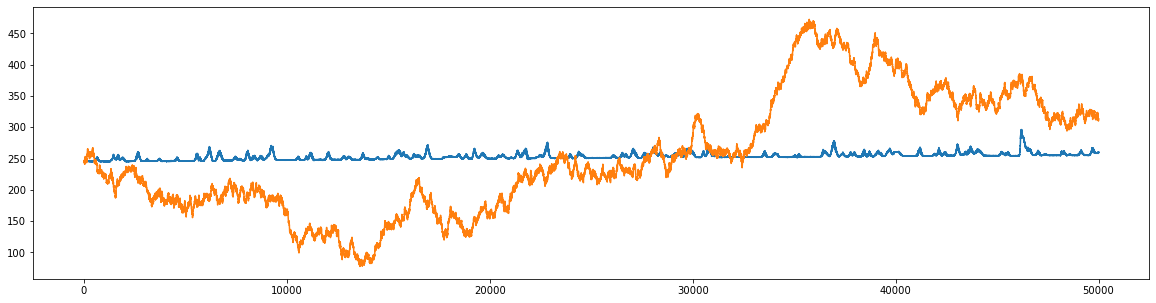

In [212]:
plt.figure(figsize=(20,5))
plt.plot(measurements.values)
plt.plot(filtered_data)

In [15]:
import numpy as np

def generate_particles(x, y, num_particles, sigma_x, sigma_y):
    particles = np.zeros((num_particles, len(x)))
    for i in range(num_particles):
        particles[i] = np.sin(x) + np.random.normal(0, sigma_x, len(x))
    return particles

def evaluate_particles(particles, y, sigma_y):
    num_particles = particles.shape[0]
    weights = np.zeros(num_particles)
    for i in range(num_particles):
        weights[i] = np.exp(-np.sum((particles[i] - y) ** 2) / (2 * sigma_y ** 2))
    weights /= np.sum(weights)
    return weights

def resample_particles(particles, weights):
    num_particles = particles.shape[0]
    new_particles = np.zeros_like(particles)
    cumulative_weights = np.cumsum(weights)
    index = np.random.rand() / num_particles
    i, j = 0, 0
    while i < num_particles:
        if index > cumulative_weights[j]:
            j += 1
        else:
            new_particles[i] = particles[j]
            i += 1
            index += 1 / num_particles
    return new_particles

def denoise_signal(x, y, num_particles, sigma_x, sigma_y):
    particles = generate_particles(x, y, num_particles, sigma_x, sigma_y)
    weights = evaluate_particles(particles, y, sigma_y)
    for i in range(100):
        particles = resample_particles(particles, weights)
        particles = generate_particles(x, y, num_particles, sigma_x, sigma_y)
        weights = evaluate_particles(particles, y, sigma_y)
    return np.mean(particles, axis=0)

In [29]:
start = 990000
stop = 1000000

x = BCN_signals.iloc[start:stop].reset_index().index
y = BCN_signals.iloc[start:stop,3].values
num_particles = 10
sigma_x = 1
sigma_y = 1e-5

denoised_signal = denoise_signal(x, y, num_particles, sigma_x, sigma_y)

C:\Users\Max\AppData\Local\Temp\ipykernel_46928\984929061.py:14: RuntimeWarning: invalid value encountered in true_divide
  weights /= np.sum(weights)
C:\Users\Max\AppData\Local\Temp\ipykernel_46928\984929061.py:14: RuntimeWarning: invalid value encountered in true_divide
  weights /= np.sum(weights)
C:\Users\Max\AppData\Local\Temp\ipykernel_46928\984929061.py:14: RuntimeWarning: invalid value encountered in true_divide
  weights /= np.sum(weights)
C:\Users\Max\AppData\Local\Temp\ipykernel_46928\984929061.py:14: RuntimeWarning: invalid value encountered in true_divide
  weights /= np.sum(weights)
C:\Users\Max\AppData\Local\Temp\ipykernel_46928\984929061.py:14: RuntimeWarning: invalid value encountered in true_divide
  weights /= np.sum(weights)
C:\Users\Max\AppData\Local\Temp\ipykernel_46928\984929061.py:14: RuntimeWarning: invalid value encountered in true_divide
  weights /= np.sum(weights)
C:\Users\Max\AppData\Local\Temp\ipykernel_46928\984929061.py:14: RuntimeWarning: invalid value

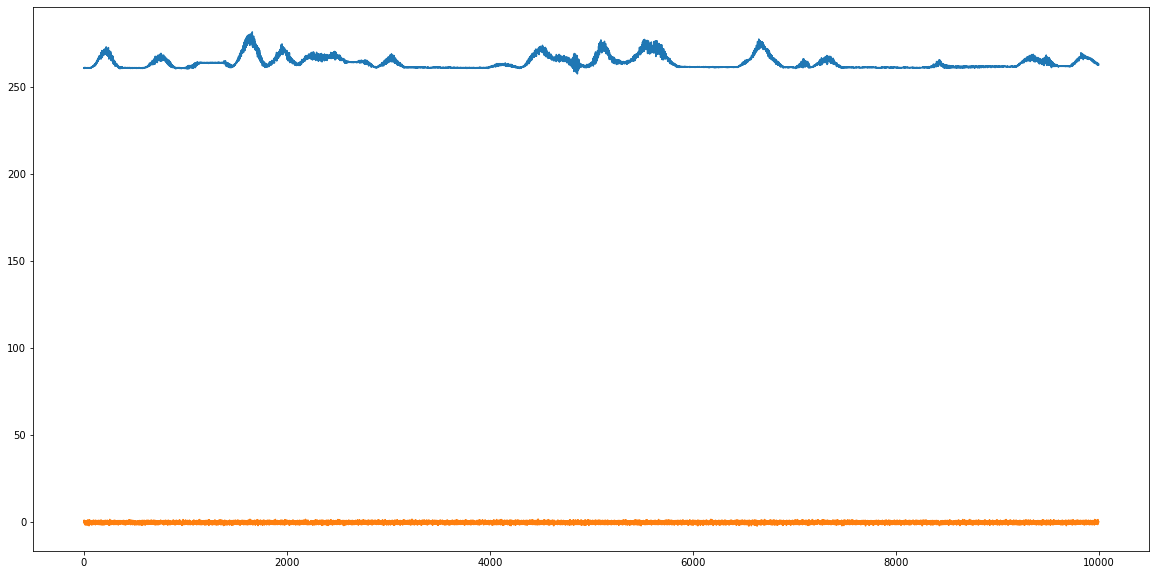

In [30]:
plt.figure(figsize=(20,10))
plt.plot(y)
plt.plot(denoised_signal)

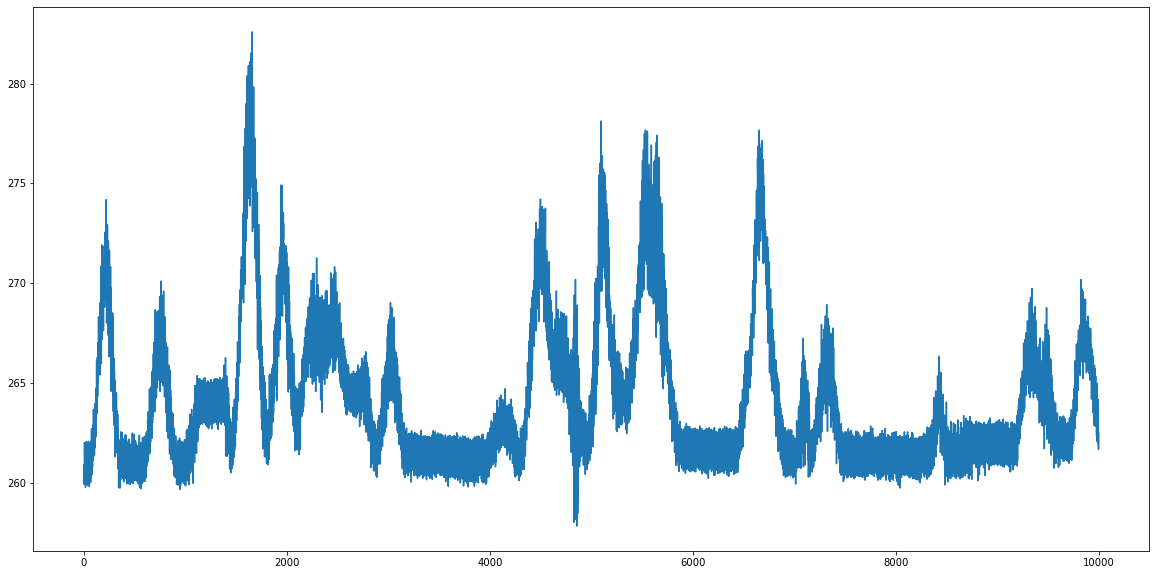

In [26]:
plt.figure(figsize=(20,10))
plt.plot(y - denoised_signal)

In [61]:
from dataclasses import dataclass

@dataclass
class ParticleFilter1D:
    """Particle filter for 1D data."""
    measurements: np.ndarray
    inputs: np.ndarray
    num_particles: int

    def __post_init__(self):
        self.particles: float = np.ones(num_particles) * self.measurements[0] # x^_0
        self.weights: np.ndarray = np.ones(self.num_particles) / self.num_particles # w^_0

    def evaluate_weights(self):
        """Evaluate weights."""
        self.weights *= self._likelihood(self.measurement, self.particles, self.input)
        self.weights /= np.sum(self.weights)


In [59]:
start = 990000
stop = 1000000

x = BCN_signals.iloc[start:stop].reset_index().index
y = BCN_signals.iloc[start:stop,3].values
num_particles = 100
sigma_x = 1
sigma_y = 0.5

denoised_signal = denoise_signal(x, y, num_particles, sigma_x, sigma_y)

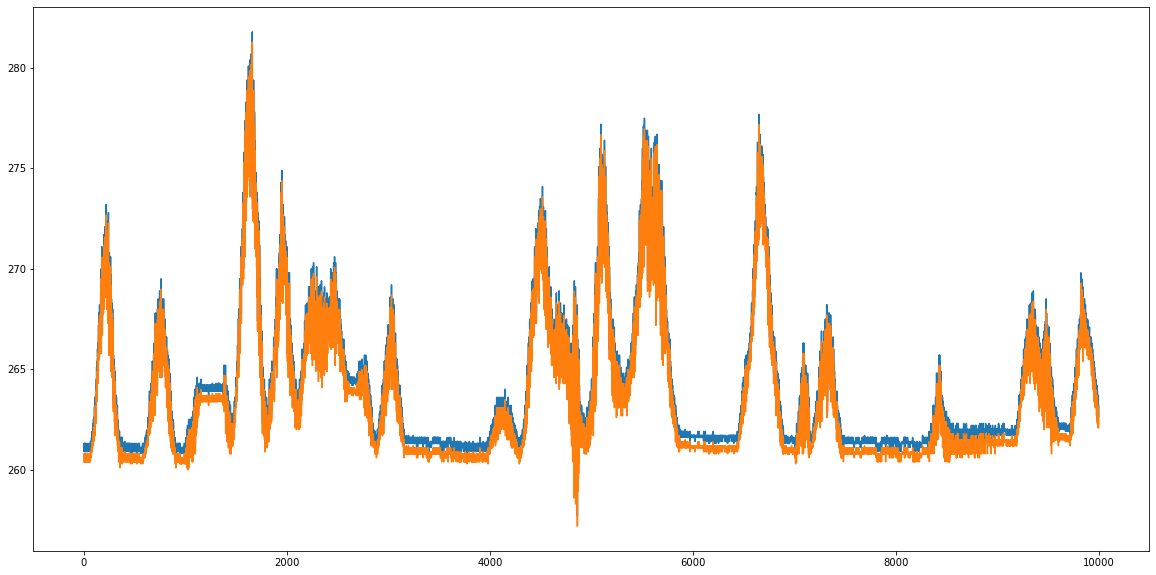

In [60]:
plt.figure(figsize=(20,10))
plt.plot(y)
plt.plot(denoised_signal)